In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time
import warnings
import os


In [40]:
start_time = time.time()
def create_fourier_features(index, periods, orders):
    """
    Create Fourier features for time series
    
    Parameters:
    -----------
    index : DatetimeIndex or RangeIndex
        Index for the features
    periods : list of int
        List of seasonality periods (e.g., [24, 168] for daily and weekly)
    orders : list of int
        Number of Fourier term pairs for each period
        
    Returns:
    --------
    DataFrame with Fourier features
    """
    features = pd.DataFrame(index=index)
    
    # Create a sequential time index
    t = np.arange(len(index))
    
    for period, order in zip(periods, orders):
        for k in range(1, order + 1):
            # Sine and cosine components
            features[f'sin_{period}_{k}'] = np.sin(2 * np.pi * k * t / period)
            features[f'cos_{period}_{k}'] = np.cos(2 * np.pi * k * t / period)
    
    return features


In [41]:
df = pd.read_parquet('../../data/data_CI.parquet')
df['DATETIME'] = pd.to_datetime(df['DATETIME'])

# Split data: Training (pre-2025) and Testing (2025)
df_filtered = df[df['DATETIME'].dt.year < 2025].copy().set_index('DATETIME')
df_2025 = df[df['DATETIME'].dt.year == 2025].copy().set_index('DATETIME')

# Train on last 90 days
data_train = df_filtered['CARBON_INTENSITY'].resample('h').mean().interpolate()
actual_2025 = df_2025['CARBON_INTENSITY'].resample('h').mean().interpolate()

# Define seasonalities: daily (24h) and weekly (168h)
periods = [24, 168]
orders = [4, 3]  # Number of Fourier terms for each period

# Create features for training data
X_train = create_fourier_features(data_train.index, periods, orders)
print(f"Training features shape: {X_train.shape}")
print(f"Feature columns: {list(X_train.columns[:6])}... (showing first 6)")

# Create features for test data
train_length = len(data_train)
test_index_with_offset = pd.RangeIndex(start=train_length, stop=train_length + len(actual_2025))

# Create features with the offset
X_test_temp = create_fourier_features(test_index_with_offset, periods, orders)
# Set the actual datetime index
X_test = X_test_temp.copy()
X_test.index = actual_2025.index

Training features shape: (87672, 14)
Feature columns: ['sin_24_1', 'cos_24_1', 'sin_24_2', 'cos_24_2', 'sin_24_3', 'cos_24_3']... (showing first 6)


In [42]:
# SARIMAX model
# Since Fourier features handle seasonality, we don't need seasonal ARIMA components
model = SARIMAX(
    data_train,
    exog=X_train,
    order=(1, 1, 1),  # ARIMA(1,1,1)
    seasonal_order=(0, 0, 0, 0),  # No seasonal ARIMA (Fourier handles it)
    enforce_stationarity=False,
    enforce_invertibility=False
)

# Fit the model
model_fit = model.fit(disp=False, maxiter=100)

In [43]:
forecast = model_fit.forecast(steps=len(actual_2025), exog=X_test)


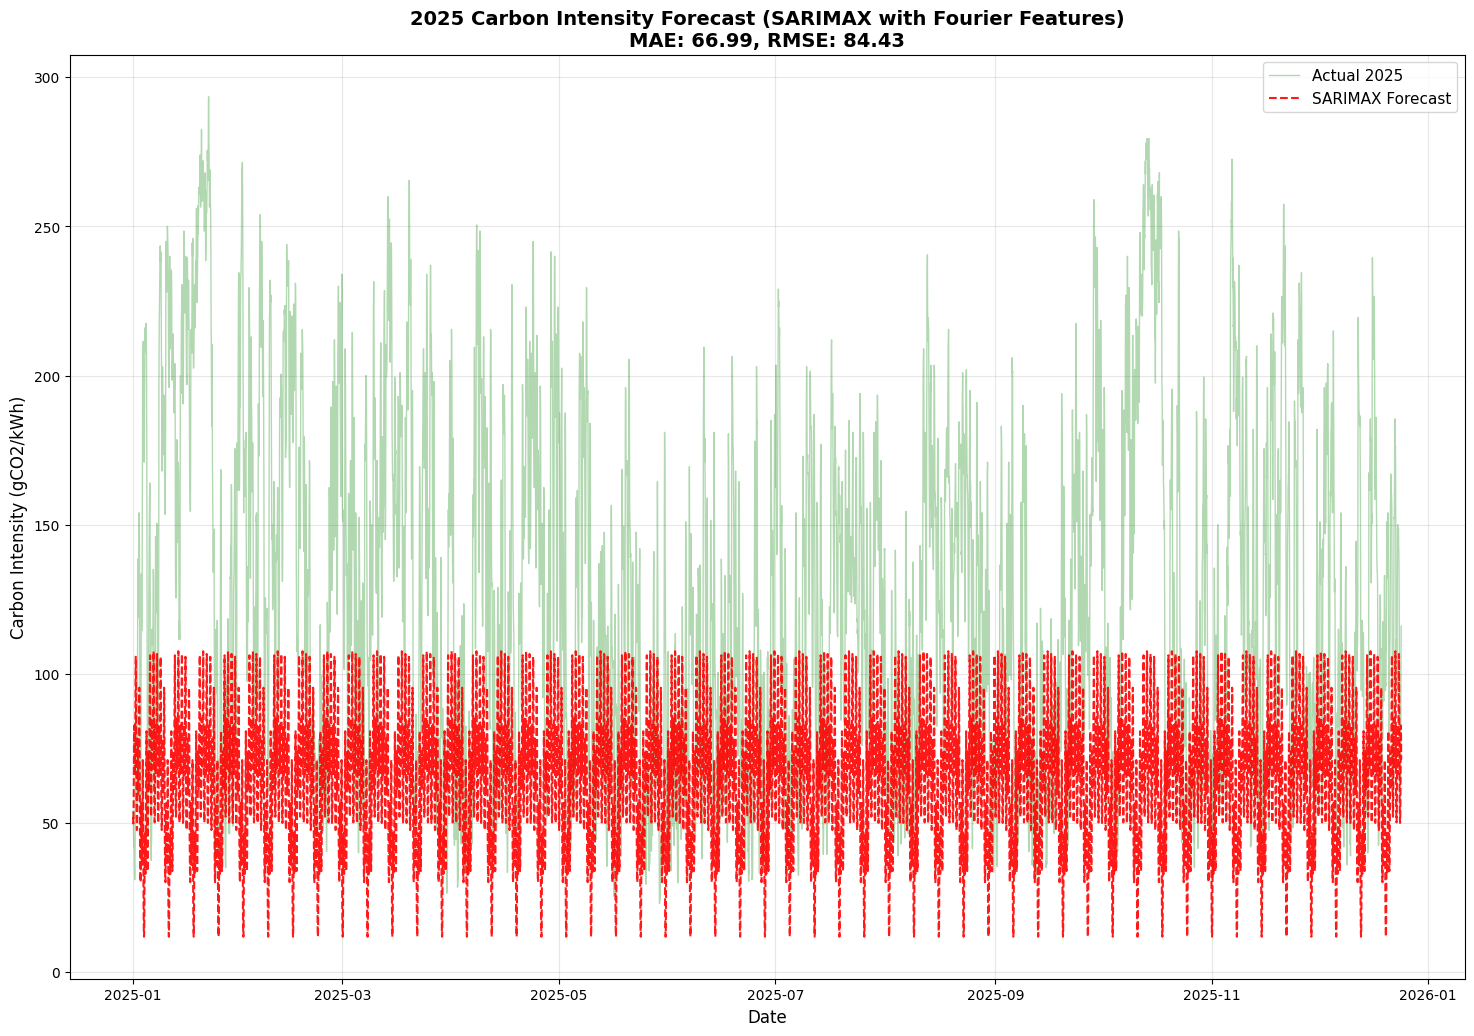

Total execution time: 37.11 seconds


In [44]:
mae = mean_absolute_error(actual_2025, forecast)
rmse = np.sqrt(mean_squared_error(actual_2025, forecast))

fig, axes = plt.subplots(1, 1, figsize=(18, 12))

# Full year forecast
axes.plot(actual_2025.index, actual_2025, label='Actual 2025', 
             color='green', alpha=0.3, linewidth=1)
axes.plot(forecast.index, forecast, label='SARIMAX Forecast', 
             color='red', linestyle='--', alpha=0.9, linewidth=1.5)
axes.set_title(f'2025 Carbon Intensity Forecast (SARIMAX with Fourier Features)\n' +
                  f'MAE: {mae:.2f}, RMSE: {rmse:.2f}',
                  fontsize=14, fontweight='bold')
axes.set_xlabel('Date', fontsize=12)
axes.set_ylabel('Carbon Intensity (gCO2/kWh)', fontsize=12)
axes.legend(fontsize=11)
axes.grid(True, alpha=0.3)

plt.show()
total_time = time.time() - start_time
print(f"Total execution time: {total_time:.2f} seconds")


In [ ]:
data_train = data_train.resample("ME").mean()
actual_2025 = actual_2025.resample("ME").mean()

In [ ]:
model = pmdarima.auto_arima(
    data_train,
    start_p=1,
    d=1,
    start_q=1,
    max_p=3,
    max_d=3,
    max_q=3,
    seasonal=True,
    m=12,
    suppress_warnings=True,
    error_action='ignore',
    n_jobs=-1,
    threads=4
)
model.fit(data_train)

In [ ]:
monthly_forecast = model.predict(n_periods=12)

In [ ]:
mae = mean_absolute_error(data_test, actual_2025)
rmse = root_mean_squared_error(data_test, actual_2025)

plt.figure(figsize=(12, 6))
plt.plot(data_test, label='Actual')
plt.plot(actual_2025, label='Predicted')
plt.legend()
plt.show()
